## Contextualización del objetivo

La presente propuesta tiene como objetivo abordar el reto de identificar casos de fraccionamiento transaccional, una práctica que consiste en dividir una transacción de mayor valor en varias transacciones menores realizadas dentro de una misma ventana de tiempo, generalmente de 24 horas, y que tienen como origen o destino la misma cuenta o cliente. Detectar este tipo de patrones es fundamental para mejorar la supervisión y gestión de transacciones, asegurando una operación más eficiente y segura.

Para resolver este desafío, se propone un enfoque estructurado que comienza con un análisis exploratorio de datos (EDA). Este paso inicial permitirá comprender en profundidad las características de las transacciones, identificar patrones generales y definir hipótesis clave que guiarán la construcción del modelo analítico. A partir del EDA, se identificarán variables relevantes y comportamientos diferenciados entre los clientes.

Posteriormente, la solución se desarrollará en dos fases principales:

- Segmentación de clientes: Se agruparán los clientes según sus comportamientos transaccionales, permitiendo diferenciar patrones normales de aquellos que podrían considerarse sospechosos. Esto asegura que las reglas aplicadas sean adaptativas y específicas para cada grupo, mejorando la precisión del análisis.
- Modelo heurístico de reglas: Una vez segmentados los clientes, se diseñará y aplicará un conjunto de reglas adaptadas a cada segmento para identificar posibles casos de fraccionamiento transaccional. Estas reglas considerarán variables como el número de transacciones, montos promedio y frecuencia, ajustándose al perfil de cada grupo.

La combinación de estas estrategias permite abordar el problema de manera eficiente y escalable, garantizando que los resultados sean interpretables y accionables. Además, la solución incluirá un componente operativo, como la generación de alertas y visualización de resultados mediante un tablero de control, facilitando la integración de esta metodología en los procesos actuales de monitoreo transaccional.

Con este enfoque, se busca demostrar habilidades analíticas, de modelado y de diseño operativo, asegurando un equilibrio entre robustez técnica y aplicabilidad práctica.

### Importe de librerias

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Cargue de datos

In [6]:
# Cargar los archivos Parquet
data_1 = pd.read_parquet('Data_1.parquet')
data_2 = pd.read_parquet('Data_2.parquet')

# Visualizar las primeras filas de cada dataset
print("Primeras filas de Data_1:")
print(data_1.head())

print("\nPrimeras filas de Data_2:")
print(data_2.head())

Primeras filas de Data_1:
                        merchant_id                               _id  \
0  075d178871d8d48502bf1f54887e52fe  aa8dacff663072244d0a8ab6bbe36b93   
1  075d178871d8d48502bf1f54887e52fe  a53bb81bd0bba2ae2535bda7ea5a550c   
2  075d178871d8d48502bf1f54887e52fe  79f893ea65c06fe2933f3847c88c272f   
3  075d178871d8d48502bf1f54887e52fe  ce577223699dbdc119df2ab8a35457fe   
4  075d178871d8d48502bf1f54887e52fe  0ce7ab2950e7a788a608f881aec0f8f0   

                         subsidiary    transaction_date  \
0  824b2af470cbe6a65b15650e03b740fc 2021-09-12 18:32:03   
1  2d8d34be7509a6b1262336d036fdb324 2021-09-12 18:31:58   
2  5eeb18254850b21af0a6bb2697913cd3 2021-09-12 18:31:56   
3  5221a599856c0a0588ed9ffd150edd3b 2021-09-12 18:31:10   
4  971e55ef12d80ec070ea4f6750c8b892 2021-09-12 18:31:07   

                     account_number                           user_id  \
0  648e257c9d74909a1f61c54b93a9e1b3  ba42d192a145583ba8e7bf04875f837f   
1  c0b62f9046c83ea5543ea46a497a4d6

In [7]:
# Información general de los datasets
print("\nInformación de Data_1:")
print(data_1.info())

print("\nInformación de Data_2:")
print(data_2.info())


Información de Data_1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10758418 entries, 0 to 10758417
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   merchant_id         object        
 1   _id                 object        
 2   subsidiary          object        
 3   transaction_date    datetime64[ns]
 4   account_number      object        
 5   user_id             object        
 6   transaction_amount  object        
 7   transaction_type    object        
dtypes: datetime64[ns](1), object(7)
memory usage: 656.6+ MB
None

Información de Data_2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10758500 entries, 0 to 10758499
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   merchant_id         object        
 1   _id                 object        
 2   subsidiary          object        
 3   transaction_date    datetime64[ns]
 4   account_numbe

In [10]:
#Como los df tienen las mismas columnas e concatenan para tener un solo df
df = pd.concat([data_1,data_2])

In [9]:
df

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type
0,075d178871d8d48502bf1f54887e52fe,aa8dacff663072244d0a8ab6bbe36b93,824b2af470cbe6a65b15650e03b740fc,2021-09-12 18:32:03,648e257c9d74909a1f61c54b93a9e1b3,ba42d192a145583ba8e7bf04875f837f,178.33365037,CREDITO
1,075d178871d8d48502bf1f54887e52fe,a53bb81bd0bba2ae2535bda7ea5a550c,2d8d34be7509a6b1262336d036fdb324,2021-09-12 18:31:58,c0b62f9046c83ea5543ea46a497a4d6e,5cfff960ea6d732c1ba3e63d24f3be52,35.66673007,CREDITO
2,075d178871d8d48502bf1f54887e52fe,79f893ea65c06fe2933f3847c88c272f,5eeb18254850b21af0a6bb2697913cd3,2021-09-12 18:31:56,872d10143fc0ac7d5de467806f6bef81,c97e63a92c82c7217b333635d75928ed,142.66692029,CREDITO
3,075d178871d8d48502bf1f54887e52fe,ce577223699dbdc119df2ab8a35457fe,5221a599856c0a0588ed9ffd150edd3b,2021-09-12 18:31:10,2e35cfe7860a480a93e1c83e99843579,fc09bdd00f283222d65eaff4d00a6594,8.32223701,CREDITO
4,075d178871d8d48502bf1f54887e52fe,0ce7ab2950e7a788a608f881aec0f8f0,971e55ef12d80ec070ea4f6750c8b892,2021-09-12 18:31:07,995bc89e4c4e00334f1f90c4a55f4729,213527e8ba94fcaf2f9378969f9f6abc,32.10005706,CREDITO
...,...,...,...,...,...,...,...,...
10758495,838a8fa992a4aa2fb5a0cf8b15b63755,d3b13edf7cb64280616840751348d916,3ed43ebad2054f6a8eff18b431f0e9a9,2021-11-29 15:48:16,8210a8f7e6b39cfc4f2b21212d18449d,69924bf8abb336410c8651f939124b48,237.77820049,CREDITO
10758496,838a8fa992a4aa2fb5a0cf8b15b63755,eadd1cc3d7f8c4a184575a3b40449015,81f8b6411c8d4f28a94fce21a134546c,2021-11-30 10:57:33,78adeb5e6eb3e03c27d8c9f078a8fd2e,e992ff01e005927af8b343385adf3744,26.15560205,CREDITO
10758497,838a8fa992a4aa2fb5a0cf8b15b63755,f19c70c14bae6f6c8d53c2a85f5f59f6,55fb0b01915693a7d5de686f9f4b1cb6,2021-11-30 11:01:07,90865ae9ab4d82a1feec13eee9a4a303,356058d6c9548879be6ef65a9733ea44,594.44550123,CREDITO
10758498,838a8fa992a4aa2fb5a0cf8b15b63755,8d43b7b55023ccae39735707a811f38f,55fb0b01915693a7d5de686f9f4b1cb6,2021-11-30 11:02:05,90865ae9ab4d82a1feec13eee9a4a303,356058d6c9548879be6ef65a9733ea44,172.38919535,CREDITO


### Analisis exploratorio de datos

In [11]:
# Ordenar las columnas por la cantidad de valores nulos de mayor a menor
null_counts = df.isnull().sum().sort_values(ascending=False)
print("Valores nulos por columna:")
print(null_counts)

Valores nulos por columna (de mayor a menor):
merchant_id           0
_id                   0
subsidiary            0
transaction_date      0
account_number        0
user_id               0
transaction_amount    0
transaction_type      0
dtype: int64


In [12]:
# Conversion 'transaction_amount' a tipo float, reemplazando errores con NaN
df['transaction_amount'] = pd.to_numeric(df['transaction_amount'], errors='coerce')

# Verificar si la conversión fue exitosa
print("\nTipos de datos después de la conversión:")
print(df.dtypes)


Tipos de datos después de la conversión:
merchant_id                   object
_id                           object
subsidiary                    object
transaction_date      datetime64[ns]
account_number                object
user_id                       object
transaction_amount           float64
transaction_type              object
dtype: object


In [14]:
print("\nResumen estadístico:")
print(df['transaction_amount'].describe())


Resumen estadístico:
count    2.151692e+07
mean     1.912898e+02
std      2.408464e+02
min      5.944455e+00
25%      3.566673e+01
50%      1.070002e+02
75%      2.377782e+02
max      4.624786e+03
Name: transaction_amount, dtype: float64


- Cantidad de transacciones: Hay más de 21 millones de transacciones registradas.
- Promedio: El monto promedio de las transacciones es de 191.29 unidades monetarias.
- Desviación estándar: Hay una alta variabilidad en los montos de las transacciones, con una desviación de 240.85 unidades monetarias.
- Valores bajos: El monto más bajo registrado es de 5.94 unidades monetarias.
- Percentil 25: El 25% de las transacciones tienen un monto de 35.67 unidades monetarias o menos.
- Mediana: El monto en el que se encuentra la mitad de las transacciones es de 107 unidades monetarias.
- Percentil 75: El 75% de las transacciones tienen un valor de 237.78 unidades monetarias o menos.
- Máximo: El monto más alto registrado es de 4,624.79 unidades monetarias.

#### Conclusiones iniciales:
- Los datos muestran una distribución asimétrica, con una tendencia hacia valores más bajos en la mayoría de las transacciones.
- La presencia de valores máximos altos en comparación con la media y los percentiles sugiere que podría haber transacciones atípicas que sería importante analizar más a fondo, especialmente en contextos como la detección de fraudes.
- La alta desviación estándar indica la necesidad de segmentar los datos o aplicar transformaciones para reducir la dispersión antes de avanzar con modelos predictivos o análisis más complejos.

In [15]:
# Resumen estadístico para columnas categóricas
print("\nColumnas categóricas - Valores únicos:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} valores únicos")


Columnas categóricas - Valores únicos:
merchant_id: 3 valores únicos
_id: 21516901 valores únicos
subsidiary: 16833 valores únicos
account_number: 3099711 valores únicos
user_id: 3087217 valores únicos
transaction_type: 2 valores únicos


C:\Users\jmlopezm\AppData\Local\anaconda3\envs\julian\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmlopezm\AppData\Local\anaconda3\envs\julian\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


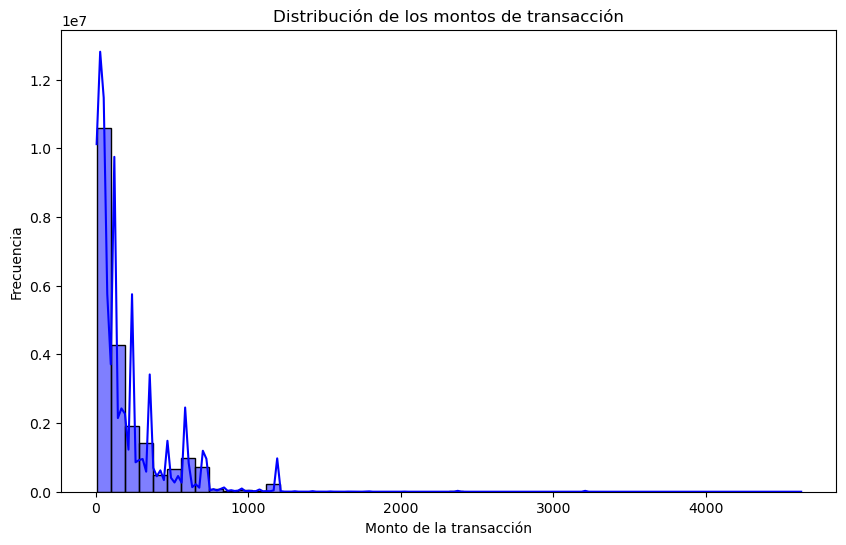

In [18]:
# Distribución de montos de transacción
plt.figure(figsize=(10, 6))
sns.histplot(df['transaction_amount'], kde=True, bins=50, color='blue')
plt.title("Distribución de los montos de transacción")
plt.xlabel("Monto de la transacción")
plt.ylabel("Frecuencia")
plt.show()

El histograma de los montos de las transacciones muestra una concentración significativa en valores bajos, con la mayoría de las transacciones cercanas al rango mínimo. Esto confirma lo observado en la descripción estadística, donde se identificó que el 75% de las transacciones tienen montos iguales o inferiores a 237.78 unidades monetarias. Aunque existen valores altos, son pocos y se consideran casos atípicos dentro de la distribución general.


Conteo de transacciones por tipo:
transaction_type
DEBITO     17183727
CREDITO     4333191
Name: count, dtype: int64


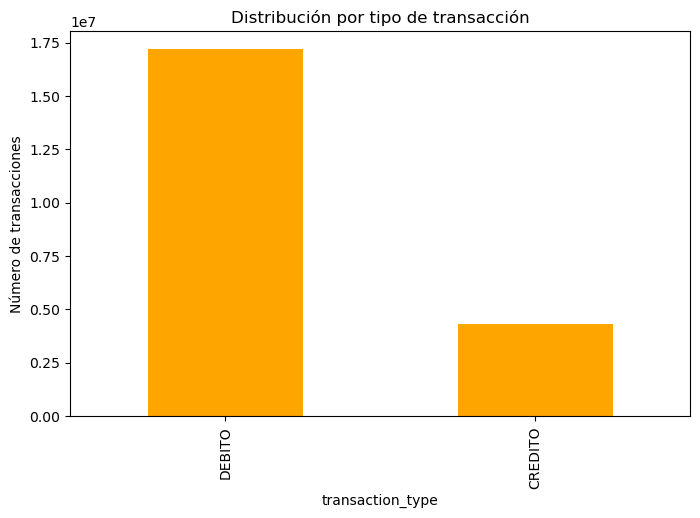

In [19]:
# Conteo de transacciones por tipo
print("\nConteo de transacciones por tipo:")
print(df['transaction_type'].value_counts())

# Gráfico de barras
df['transaction_type'].value_counts().plot(kind='bar', color='orange', figsize=(8, 5))
plt.title("Distribución por tipo de transacción")
plt.ylabel("Número de transacciones")
plt.show()

El análisis del conteo de transacciones por tipo revela que las transacciones de débito representan la mayoría, con un total de 17,183,727, mientras que las de crédito son significativamente menores, sumando 4,333,191. Esto indica que los usuarios realizan, en su mayoría, operaciones relacionadas con la salida de dinero. La marcada diferencia sugiere que, para este análisis, es clave priorizar el estudio de las transacciones de débito, ya que son las más representativas del comportamiento general y podrían estar más relacionadas con posibles prácticas de fraccionamiento transaccional.

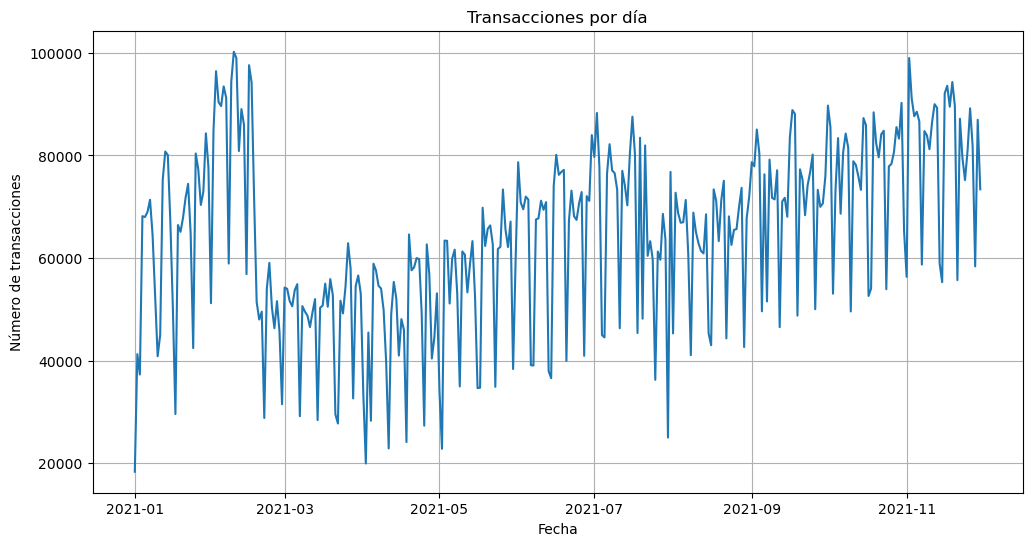

In [20]:
# Agregar columna de fecha (sin hora)
df['transaction_date_only'] = df['transaction_date'].dt.date

# Conteo de transacciones por día
daily_transactions = df.groupby('transaction_date_only').size()

# Gráfico de transacciones diarias
plt.figure(figsize=(12, 6))
daily_transactions.plot()
plt.title("Transacciones por día")
plt.xlabel("Fecha")
plt.ylabel("Número de transacciones")
plt.grid()
plt.show()

El análisis de la gráfica de transacciones por día muestra un crecimiento sostenido desde enero hasta finales de febrero, donde el volumen de transacciones aumentó de aproximadamente 40,000 a casi 100,000. Sin embargo, a inicios de marzo se observa una caída significativa en el número de transacciones. Posteriormente, el volumen ha mostrado una recuperación gradual y sostenida, alcanzando nuevamente cerca de 100,000 transacciones diarias hacia el mes de noviembre. Este comportamiento podría reflejar estacionalidades, eventos específicos o cambios en el comportamiento de los usuarios que merecen un análisis más detallado.

In [41]:
# Agregar columna con la hora de la transacción
df['transaction_hour'] = df['transaction_date'].dt.hour

# Calcular el número total de transacciones por hora
transactions_per_hour = df.groupby('transaction_hour').size()

# Calcular el promedio de transacciones por hora
avg_transactions_by_hour = transactions_per_hour / len(df['transaction_date'].dt.date.unique())

# Mostrar los resultados
print("\nPromedio de transacciones por hora:")
print(avg_transactions_by_hour)


Promedio de transacciones por hora:
transaction_hour
0      143.523952
1       79.248503
2       55.149701
3       46.347305
4       63.979042
5      170.955090
6      497.287425
7     1080.532934
8     2273.541916
9     3645.113772
10    4683.104790
11    5153.748503
12    5116.329341
13    4798.553892
14    5182.110778
15    5562.218563
16    5872.724551
17    6002.556886
18    5384.895210
19    4063.616766
20    2409.778443
21    1225.200599
22     612.080838
23     299.311377
dtype: float64


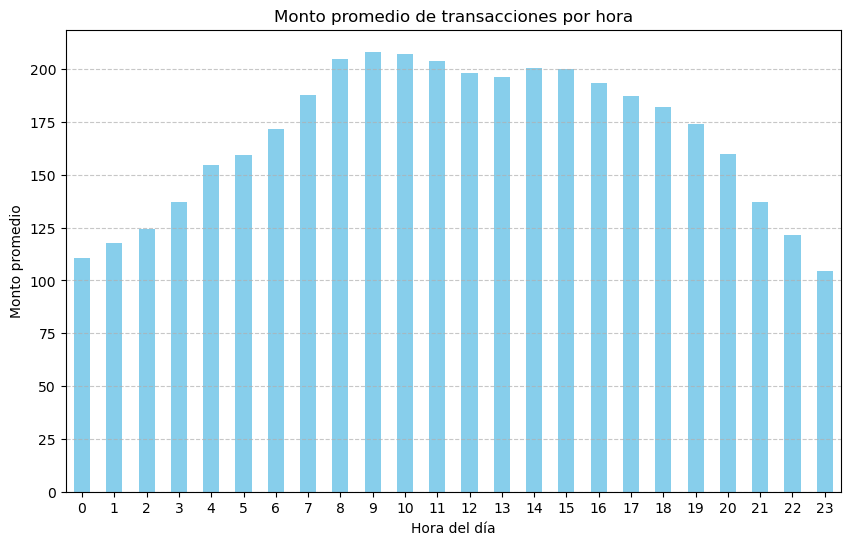

In [42]:
# Gráfico de transacciones promedio por hora
plt.figure(figsize=(10, 6))
avg_transaction_by_hour.plot(kind='bar', color='skyblue')
plt.title("Cantidad promedio de transacciones por hora")
plt.xlabel("Hora del día")
plt.ylabel("Cantidad promedio")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


- El análisis de las transacciones promedio por hora muestra un comportamiento típico del ciclo diario de actividad de los usuarios. Las horas con mayor cantidad de transacciones, como entre las 9:00 y las 18:00, coinciden con las jornadas laborales y comerciales, lo que es esperable debido a la mayor actividad económica y transaccional en estos periodos. Este patrón es consistente con el comportamiento normal de los clientes y no necesariamente implica un mayor riesgo, aunque el volumen de transacciones pueda ser elevado.

- Por otro lado, las horas con menor cantidad de transacciones, como entre la medianoche y las 6:00, representan periodos de menor actividad, lo cual también es esperable. Sin embargo, estas horas de baja transaccionalidad pueden ser más relevantes para evaluaciones de riesgo, ya que cualquier actividad inusual o volúmenes de transacciones atípicos podrían ser indicativos de comportamientos anómalos o potencialmente fraudulentos.

- En conclusión, aunque es natural observar picos en horas de mayor actividad, las horas menos comunes deben ser analizadas de manera más detallada, ya que su bajo volumen podría facilitar la detección de patrones sospechosos. Esto resalta la importancia de ajustar los modelos de riesgo según los patrones temporales de transaccionalidad.

In [43]:
# Agregar columna con el nombre del día
df['transaction_day'] = df['transaction_date'].dt.day_name()

# Contar la cantidad de transacciones por día
transaction_count_by_day = df.groupby('transaction_day').size()

# Ordenar los días de la semana correctamente
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
transaction_count_by_day = transaction_count_by_day.reindex(ordered_days)

# Calcular el promedio de transacciones por día
avg_transaction_by_day = transaction_count_by_day / df['transaction_day'].nunique()

# Mostrar los resultados
print("\nPromedio de transacciones por día:")
print(avg_transaction_by_day)


Promedio de transacciones por día:
transaction_day
Monday       442636.428571
Tuesday      481544.428571
Wednesday    465119.428571
Thursday     456960.000000
Friday       473222.714286
Saturday     466395.857143
Sunday       287966.571429
dtype: float64


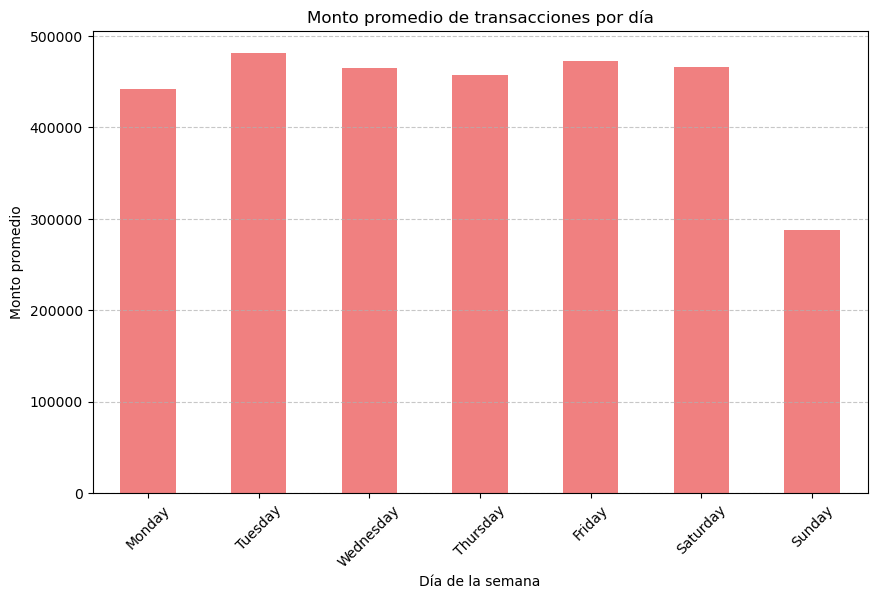

In [44]:
# Gráfico de transacciones promedio por día
plt.figure(figsize=(10, 6))
avg_transaction_by_day.plot(kind='bar', color='lightcoral')
plt.title("Cantidad promedio de transacciones por día")
plt.xlabel("Día de la semana")
plt.ylabel("Cantidad promedio")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

El análisis muestra que los días de la semana (lunes a viernes) tienen un volumen alto y similar de transacciones, con un promedio de transacciones por día que oscila entre 442,636 y 481,544. Sin embargo, el domingo presenta una disminución significativa en el número de transacciones, con un promedio de 287,967. Esto sugiere que las transacciones realizadas durante los días de semana son más comunes y podrían tener un patrón más predecible, mientras que el domingo podría representar un día de menor actividad, y su menor volumen debe ser evaluado de manera diferente en el modelo de fraude. Es importante considerar estos días con diferentes enfoques en el análisis de riesgo, ya que los patrones de fraude podrían diferir según el día de la semana.

In [62]:
# Agregar columna con el día numérico de la semana (0=Monday, 6=Sunday)
df['transaction_day_num'] = df['transaction_date'].dt.day

# Contar la cantidad de transacciones por día numérico
transaction_count_by_day_num = df.groupby('transaction_day_num').size()

# Calcular el promedio de transacciones por día numérico
avg_transaction_by_day_num = transaction_count_by_day_num / df['transaction_day_num'].nunique()

# Mostrar los resultados
print("\nPromedio de transacciones por día (número):")
print(avg_transaction_by_day_num)


Promedio de transacciones por día (número):
transaction_day_num
1     21075.935484
2     23502.903226
3     23650.225806
4     23393.129032
5     23534.741935
6     24226.677419
7     20914.225806
8     24208.903226
9     23785.580645
10    22626.838710
11    21835.483871
12    23871.580645
13    23935.483871
14    21292.193548
15    23188.451613
16    24188.161290
17    22630.774194
18    22167.193548
19    24235.935484
20    22650.612903
21    22244.000000
22    22462.677419
23    22842.516129
24    20918.870968
25    22000.193548
26    24033.709677
27    22659.870968
28    21540.677419
29    21573.258065
30    20712.064516
31    12191.258065
dtype: float64


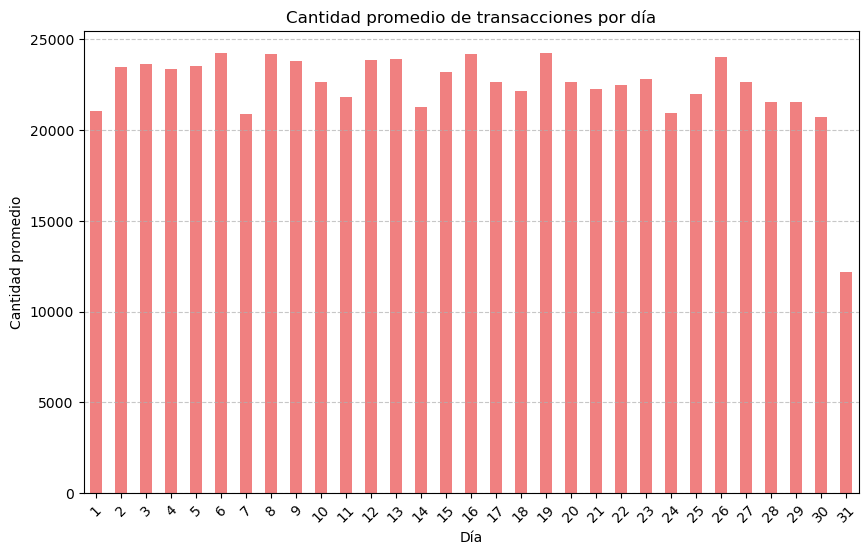

In [63]:
# Gráfico de transacciones promedio por día
plt.figure(figsize=(10, 6))
avg_transaction_by_day_num.plot(kind='bar', color='lightcoral')
plt.title("Cantidad promedio de transacciones por día")
plt.xlabel("Día")
plt.ylabel("Cantidad promedio")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

El análisis de las transacciones por día del mes muestra que, en general, las transacciones se distribuyen de manera relativamente estable a lo largo del mes. Sin embargo, se pueden observar ciertos patrones y picos en días específicos.

Los días 6, 8, 12, 13, 16 y 19 tienen un número significativamente más alto de transacciones, con valores superiores a los 24,000. Estos días podrían representar días de alta actividad o eventos especiales que impulsan un mayor volumen de transacciones.

In [48]:
# Agregar columna con el mes
df['transaction_month'] = df['transaction_date'].dt.month_name()

# Promedio de transacciones por mes (contando las transacciones)
avg_transaction_by_month = df.groupby('transaction_month').size() / df['transaction_month'].nunique()

# Ordenar los meses correctamente
ordered_months = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
avg_transaction_by_month = avg_transaction_by_month.reindex(ordered_months)

# Mostrar los resultados
print("\nPromedio de transacciones por mes:")
print(avg_transaction_by_month)



Promedio de transacciones por mes:
transaction_month
January      175097.818182
February     180960.545455
March        138085.909091
April        128607.000000
May          155920.454545
June         179421.727273
July         188187.454545
August       177814.909091
September    196100.636364
October      215448.272727
November     220438.727273
December               NaN
dtype: float64


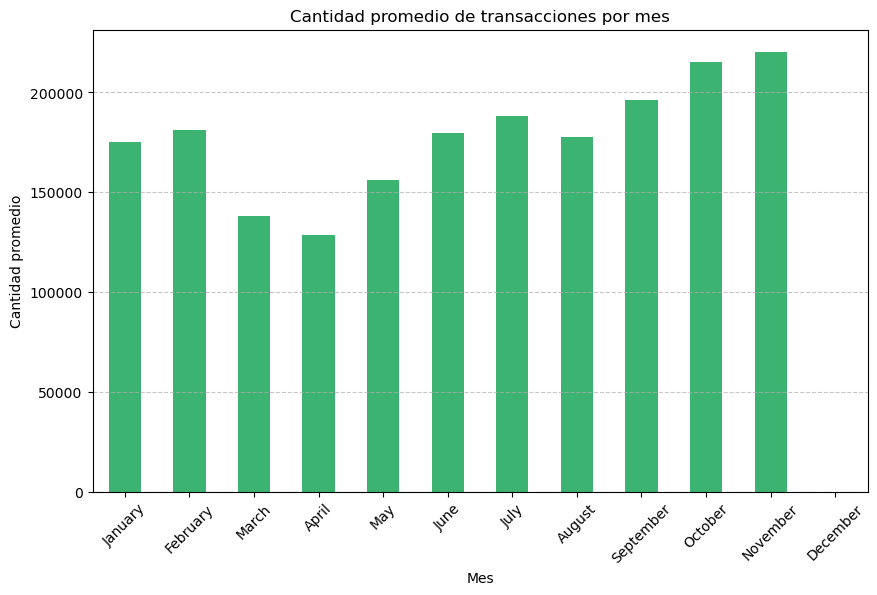

In [46]:
# Gráfico de transacciones promedio por mes
plt.figure(figsize=(10, 6))
avg_transaction_by_month.plot(kind='bar', color='mediumseagreen')
plt.title("Cantidad promedio de transacciones por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad promedio")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


El promedio de transacciones por mes muestra un crecimiento constante en la cantidad de transacciones desde enero hasta noviembre. Se observa un pico de transacciones en octubre y noviembre, con valores alrededor de 220,000 transacciones en promedio. Los meses de marzo y abril tienen un descenso notable en comparación con los demás, con valores cercanos a 130,000, mientras que los meses de febrero, mayo, y junio están relativamente estables alrededor de 180,000 transacciones en promedio. 

In [49]:
# Agregar columna con el mes
df['transaction_month'] = df['transaction_date'].dt.month_name()
# Promedio de transacciones por mes
avg_transaction_by_month_amount = df.groupby('transaction_month')['transaction_amount'].mean()

# Ordenar los meses correctamente
ordered_months = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
avg_transaction_by_month_amount = avg_transaction_by_month_amount.reindex(ordered_months)

# Mostrar los resultados
print("\nPromedio de transacciones por mes:")
print(avg_transaction_by_month_amount)


Promedio de transacciones por mes:
transaction_month
January      120.617619
February     135.711925
March        192.872240
April        193.188588
May          195.378174
June         195.500885
July         204.869637
August       209.543625
September    207.039864
October      212.800568
November     223.279948
December            NaN
Name: transaction_amount, dtype: float64


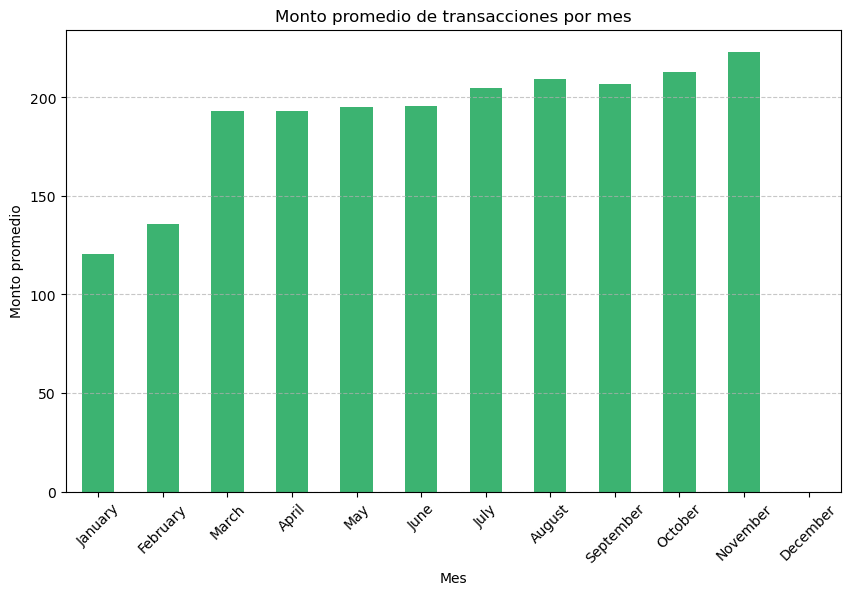

In [50]:
# Gráfico de transacciones promedio por mes
plt.figure(figsize=(10, 6))
avg_transaction_by_month_amount.plot(kind='bar', color='mediumseagreen')
plt.title("Monto promedio de transacciones por mes")
plt.xlabel("Mes")
plt.ylabel("Monto promedio")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

El análisis de los montos promedio de las transacciones por mes muestra un patrón claro de aumento constante a lo largo del año. Desde enero hasta noviembre, los clientes parecen estar incrementando gradualmente el valor de sus transacciones, con el monto promedio pasando de 120.6 en enero a 223.3 en noviembre. Este crecimiento podría indicar una tendencia hacia transacciones de mayor valor, situacion bastante relevante para evaluar el riesgo de fraude. 


Top 10 Comercios con más transacciones:
merchant_id
817d18cd3c31e40e9bff0566baae7758    14534300
838a8fa992a4aa2fb5a0cf8b15b63755     3753400
075d178871d8d48502bf1f54887e52fe     3229218
Name: count, dtype: int64


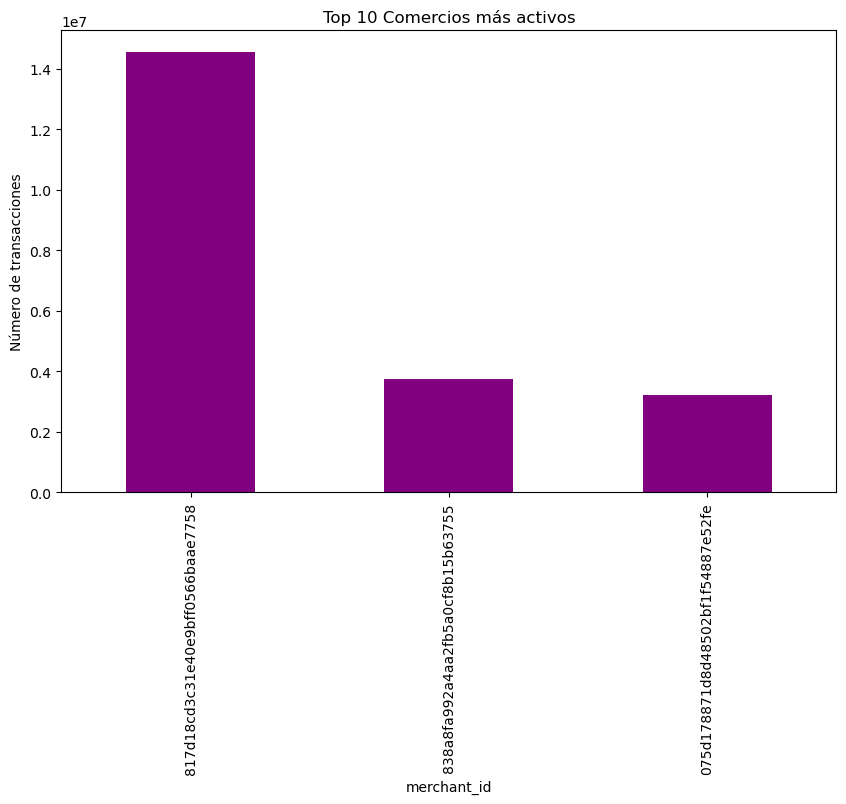

In [21]:
# Comercios con mayor número de transacciones
top_merchants = df['merchant_id'].value_counts().head(10)
print("\nTop 10 Comercios con más transacciones:")
print(top_merchants)

# Gráfico
top_merchants.plot(kind='bar', figsize=(10, 6), color='purple')
plt.title("Top 10 Comercios más activos")
plt.ylabel("Número de transacciones")
plt.show()

En particular, el comercio con el ID 817d18cd3c31e40e9bff0566baae7758 tiene una cantidad de transacciones significativamente mayor que el resto, con 14,534,300 transacciones, lo que podría indicar que es un comercio de alto volumen o con una clientela bastante activa. Los otros comercios también muestran una fuerte presencia, pero con una cantidad mucho menor de transacciones.

Este análisis podría ser útil para enfocar las estrategias de monitoreo de fraude, ya que los comercios con mayor volumen de transacciones podrían ser más susceptibles a incidentes de fraude debido al alto número de transacciones diarias.


Top 10 Usuarios con más transacciones:
user_id
5e674596af22a66e826bf15b2a363cce    3883
d3720205290ca7444d216167dd4cb0b1    3525
e77fc30bb3bec8bf45a35b535b292047    2834
93bb7c11b0b58e233f56f50cd70c1a82    2393
0457e033945b37b94d7f396aa07daaa1    2362
84d55acc72d398e26fc939d06d17fdb4    2200
7fda354dbc3e684bf414d3ab27208d79    2192
cd15ab893db3f4ee8c43de00e2c42e51    2143
483525c557cb54274c1a68438e0ebe45    2110
09ef9d0c0923b7f4848655f0de449603    2038
Name: count, dtype: int64


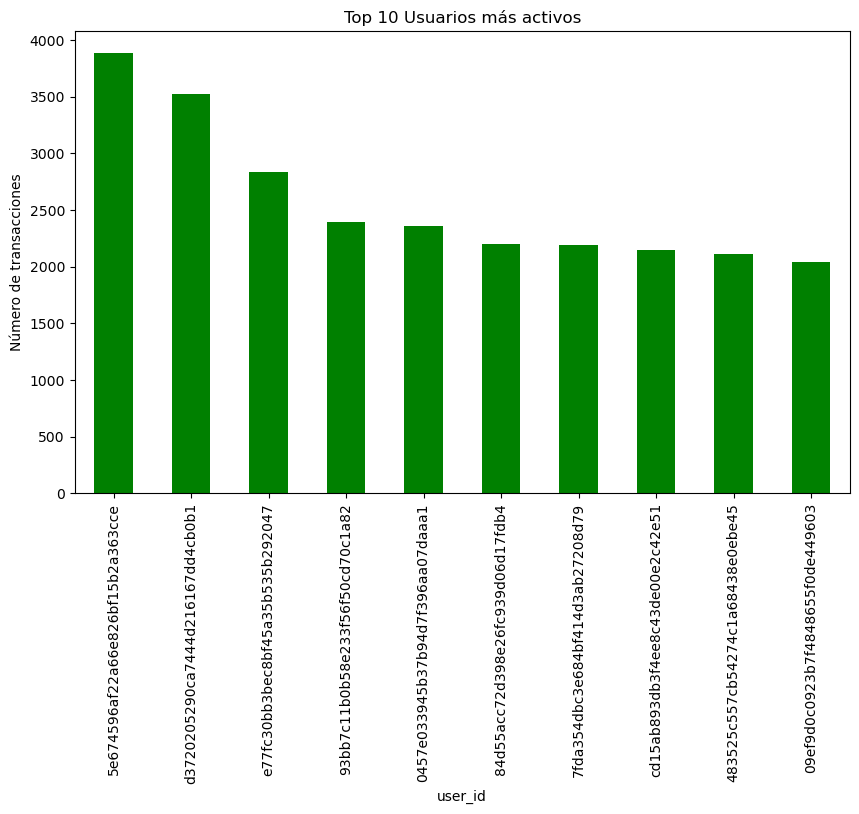

In [22]:
# Usuarios con mayor número de transacciones
top_users = df['user_id'].value_counts().head(10)
print("\nTop 10 Usuarios con más transacciones:")
print(top_users)

# Gráfico
top_users.plot(kind='bar', figsize=(10, 6), color='green')
plt.title("Top 10 Usuarios más activos")
plt.ylabel("Número de transacciones")
plt.show()

- Aunque estos 10 usuarios tienen un número de transacciones relativamente alto, representan solo un 0.13% del total de transacciones. Esto sugiere que, aunque estos usuarios son activos, el volumen de transacciones está altamente distribuido entre una gran cantidad de otros usuarios.

- En términos de análisis de fraude, estos usuarios, aunque representan una pequeña fracción del total, podrían ser relevantes para monitorear debido a su alto volumen de transacciones. 

- Del mismo modo, pueden afectar fuertemente las reglas de un modelo heuristico, lo que corrobora la necesidad de mapear diferentes segmentos


Monto promedio por tipo de transacción:
transaction_type
CREDITO    137.87044
DEBITO     204.76051
Name: transaction_amount, dtype: float64


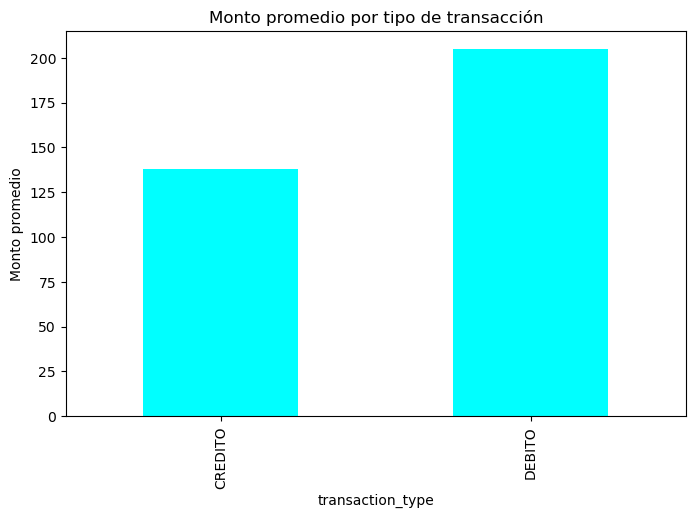

In [23]:
# Monto promedio por tipo de transacción
avg_amount_by_type = df.groupby('transaction_type')['transaction_amount'].mean()
print("\nMonto promedio por tipo de transacción:")
print(avg_amount_by_type)

# Gráfico
avg_amount_by_type.plot(kind='bar', color='cyan', figsize=(8, 5))
plt.title("Monto promedio por tipo de transacción")
plt.ylabel("Monto promedio")
plt.show()

- Transacciones de débito (salida de dinero): El monto promedio por transacción es 204.76 unidades monetarias.
- Transacciones de crédito (entrada de dinero): El monto promedio por transacción es 137.87 unidades monetarias.
- Este análisis indica que las transacciones de débito, que representan una salida de dinero, tienen un monto promedio superior al de las transacciones de crédito, que representan una entrada de dinero. 
- Desde el punto de vista del riesgo de fraude, las transacciones de débito son más sensibles, ya que implican una salida de dinero, lo que podría ser más perjudicial en caso de fraude.

C:\Users\jmlopezm\AppData\Local\anaconda3\envs\julian\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmlopezm\AppData\Local\anaconda3\envs\julian\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmlopezm\AppData\Local\anaconda3\envs\julian\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


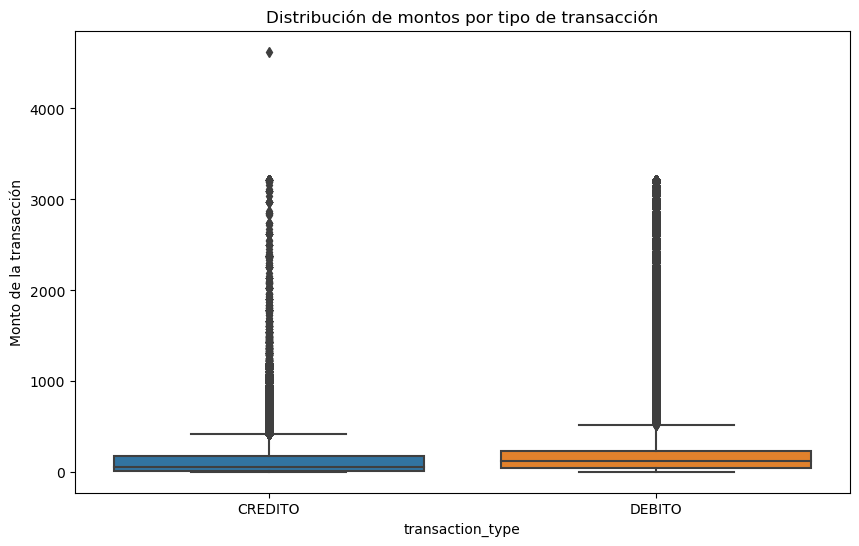

In [24]:
# Boxplot para detectar outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='transaction_type', y='transaction_amount', data=df)
plt.title("Distribución de montos por tipo de transacción")
plt.ylabel("Monto de la transacción")
plt.show()

In [25]:
duplicated = df.duplicated().sum()
print(f"Número de transacciones duplicadas: {duplicated}")

Número de transacciones duplicadas: 11


Hay 11 tx duplicadas, las cuales se deben eliminar al momento de modelar

In [26]:
zero_amounts = (df['transaction_amount'] == 0).sum()
print(f"Transacciones con monto igual a 0: {zero_amounts}")

Transacciones con monto igual a 0: 0


No se presentan transacciones con errores

In [35]:
#Calcular el número de transacciones por usuario
transactions_per_user = df.groupby('user_id').size()

# Calcular cuartiles
q1, q2, q3 = transactions_per_user.quantile([0.25, 0.5, 0.75])

# Mostrar resultados
print(f"Q1: {q1:.2f} transacciones")
print(f"Q2 (mediana): {q2:.2f} transacciones")
print(f"Q3: {q3:.2f} transacciones")

Q1: 1.00 transacciones
Q2 (mediana): 3.00 transacciones
Q3: 7.00 transacciones


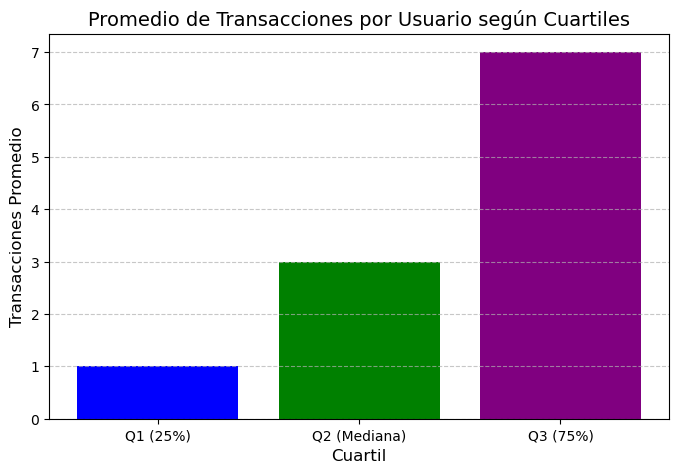

In [38]:
# Crear un DataFrame para los cuartiles
quartiles = pd.DataFrame({
    'Cuartil': ['Q1 (25%)', 'Q2 (Mediana)', 'Q3 (75%)'],
    'Transacciones Promedio': [q1, q2, q3]
})

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(quartiles['Cuartil'], quartiles['Transacciones Promedio'], color=['blue', 'green', 'purple'])

# Añadir etiquetas y título
plt.title("Promedio de Transacciones por Usuario según Cuartiles", fontsize=14)
plt.ylabel("Transacciones Promedio", fontsize=12)
plt.xlabel("Cuartil", fontsize=12)


# Mostrar gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Tratamiento de datos


Dado que, según el análisis exploratorio de datos (EDA), la información parece estar estable, sin valores nulos ni registros erróneos, la principal necesidad es abordar los valores atípicos presentes en los montos de las transacciones. Para gestionar este aspecto, se optará por un análisis basado en percentiles, lo cual permitirá determinar un límite adecuado hasta el cual los montos pueden considerarse dentro de un rango aceptable, facilitando así una mejor interpretación y manejo de la data.

In [52]:
# Calcular los percentiles (25, 75 y 99) para transaction_amount
q25, q75, q99 = np.percentile(df['transaction_amount'].values, [25, 75, 99])

# Calcular el rango intercuartílico (IQR)
iqr = q75 - q25

# Calcular los límites para los valores atípicos
minimo_valoriqr = q25 - 1.5 * iqr
maximo_valoriqr = q75 + 1.5 * iqr
maximo_valor99 = q99

# Crear máscaras para identificar outliers
mascara_outliers_valoriqr = (df['transaction_amount'] < minimo_valoriqr) | (df['transaction_amount'] > maximo_valoriqr)
mascara_p99 = (df['transaction_amount'] > maximo_valor99)

# Imprimir resultados
print(f'Para el valor de las transacciones, se han identificado {mascara_outliers_valoriqr.sum()} valores atípicos según el rango IQR.')
print(f'Estos valores están por debajo de {minimo_valoriqr:.2f} y/o por encima de {maximo_valoriqr:.2f}, que son el rango mínimo y máximo del IQR respectivamente.')
print(f'Además, al considerar el percentil 99, se detectan {mascara_p99.sum()} valores atípicos, el valor máximo es {maximo_valor99:.2f}.')

Para el valor de las transacciones, se han identificado 2229872 valores atípicos según el rango IQR.
Estos valores están por debajo de -267.50 y/o por encima de 540.95, que son el rango mínimo y máximo del IQR respectivamente.
Además, al considerar el percentil 99, se detectan 53201 valores atípicos, el valor máximo es 1188.89.


- Dado el análisis realizado, se decide optar por el percentil 99 como criterio para tratar los valores atípicos. El uso del rango intercuartílico (IQR) genera una cantidad significativa de datos fuera del rango, lo que podría dejar muchos registros sin un análisis adecuado.

- Debido a que se trabaja con transacciones financieras y en un contexto de control de riesgos, es prohibido eliminar registros, ya que cada transacción puede ser crítica para los modelos de monitoreo y prevención. Por ello, se optará por reemplazar los valores superiores al percentil 99 por el valor correspondiente al percentil 99, asegurando así la estabilidad del análisis sin comprometer la calidad de la información y respetando la integridad de los datos.

In [54]:
# Crear una nueva columna donde los valores superiores al percentil 99 se reemplazan por el valor del percentil
df['amount_trans'] = np.where(df['transaction_amount'] > maximo_valor99, maximo_valor99, df['transaction_amount'])

In [55]:
df['amount_trans'].describe()

count    2.151692e+07
mean     1.893202e+02
std      2.270383e+02
min      5.944455e+00
25%      3.566673e+01
50%      1.070002e+02
75%      2.377782e+02
max      1.188891e+03
Name: amount_trans, dtype: float64

### Featuring de variables

El proceso de agregar las columnas de hora, día en nombre, día en número y mes a las transacciones tiene como objetivo enriquecer el análisis para el control de riesgo transaccional y la segmentación de usuarios. Al incluir la hora, se puede identificar patrones en cuanto a los momentos del día en que ocurren las transacciones, lo que podría ayudar a detectar comportamientos atípicos o sospechosos asociados a ciertos horarios. La inclusión del día en nombre y en número permite entender la distribución de las transacciones a lo largo de la semana y del mes, facilitando la identificación de días con un volumen inusualmente alto o bajo de actividad

In [64]:
# Agregar la columna 'hora' (hora de la transacción)
df['hora'] = df['transaction_date'].dt.hour

# Agregar la columna 'transaction_day_name' (nombre del día de la semana)
df['transaction_day_name'] = df['transaction_date'].dt.day_name()

# Agregar la columna 'transaction_day_num' (día del mes en número)
df['transaction_day_num'] = df['transaction_date'].dt.day

# Agregar la columna 'transaction_month' (mes de la transacción)
df['transaction_month'] = df['transaction_date'].dt.month_name()


Las variables creadas, como la cantidad de transacciones de débito y crédito, así como los montos acumulados, se utilizarán para segmentar a los clientes según su comportamiento transaccional. Estas métricas permitirán identificar patrones, como la frecuencia de uso de los métodos de pago, el volumen de compras y la regularidad de las transacciones. Al segmentar a los clientes con base en estos parámetros, se podrán aplicar estrategias de control de riesgo más eficaces, personalizar ofertas y monitorear comportamientos inusuales que podrían indicar fraude o comportamientos atípicos.

In [67]:
# Filtrar las transacciones de tipo "débito" y "crédito"
df_debito = df[df['transaction_type'].str.upper() == "DEBITO"]
df_credito = df[df['transaction_type'].str.upper() == "CREDITO"]

In [71]:
# Crear un DataFrame con transacciones por usuario para débito
transactions_per_user_debito = df_debito.groupby('user_id').agg(
    total_debito_transactions=('transaction_date', 'count'),  # Total de transacciones débito
    Promedio_debito_amount=('amount_trans', 'mean'),         # Monto total de débito
    first_transaction_debito=('transaction_date', 'min'),      # Fecha y hora de la primera transacción débito
    last_transaction_debito=('transaction_date', 'max')        # Fecha y hora de la última transacción débito
).reset_index()

In [72]:
# Crear un DataFrame con transacciones por usuario para crédito
transactions_per_user_credito = df_credito.groupby('user_id').agg(
    total_credito_transactions=('transaction_date', 'count'),  # Total de transacciones crédito
    Promedio_credito_amount=('amount_trans', 'mean'),        # Monto total de crédito
    first_transaction_credito=('transaction_date', 'min'),     # Fecha y hora de la primera transacción crédito
    last_transaction_credito=('transaction_date', 'max')       # Fecha y hora de la última transacción crédito
).reset_index()

In [73]:
# Fusionar los DataFrames de débito y crédito por 'user_id'
transactions_per_user = pd.merge(transactions_per_user_debito, transactions_per_user_credito, on='user_id', how='left')

# Calcular la duración en horas, días, semanas y meses para cada usuario
transactions_per_user['hours_active'] = (transactions_per_user['last_transaction_debito'] - transactions_per_user['first_transaction_debito']).dt.total_seconds() / 3600
transactions_per_user['days_active'] = (transactions_per_user['last_transaction_debito'] - transactions_per_user['first_transaction_debito']).dt.days + 1
transactions_per_user['weeks_active'] = transactions_per_user['days_active'] / 7
transactions_per_user['months_active'] = transactions_per_user['days_active'] / 30  # Aproximación de meses

# Calcular el promedio de transacciones por hora, día, semana y mes para débito y crédito
transactions_per_user['transactions_per_hour_debito'] = transactions_per_user['total_debito_transactions'] / transactions_per_user['hours_active']
transactions_per_user['transactions_per_day_debito'] = transactions_per_user['total_debito_transactions'] / transactions_per_user['days_active']
transactions_per_user['transactions_per_week_debito'] = transactions_per_user['total_debito_transactions'] / transactions_per_user['weeks_active']
transactions_per_user['transactions_per_month_debito'] = transactions_per_user['total_debito_transactions'] / transactions_per_user['months_active']

transactions_per_user['transactions_per_hour_credito'] = transactions_per_user['total_credito_transactions'] / transactions_per_user['hours_active']
transactions_per_user['transactions_per_day_credito'] = transactions_per_user['total_credito_transactions'] / transactions_per_user['days_active']
transactions_per_user['transactions_per_week_credito'] = transactions_per_user['total_credito_transactions'] / transactions_per_user['weeks_active']
transactions_per_user['transactions_per_month_credito'] = transactions_per_user['total_credito_transactions'] / transactions_per_user['months_active']

# Seleccionar las columnas relevantes
result = transactions_per_user[['user_id', 
                                'total_debito_transactions', 
                                'total_credito_transactions', 
                                'Promedio_debito_amount', 
                                'Promedio_credito_amount', 
                                'transactions_per_hour_debito', 
                                'transactions_per_day_debito', 
                                'transactions_per_week_debito', 
                                'transactions_per_month_debito', 
                                'transactions_per_hour_credito', 
                                'transactions_per_day_credito', 
                                'transactions_per_week_credito', 
                                'transactions_per_month_credito']]



                            user_id  total_debito_transactions  \
0  00000158a82e34eb0848d767d09f811d                         11   
1  000004f4a6f3ac93f454a5dc04b2a252                          8   
2  00000c80915f64c9bcbf1e85a2e5f3ec                          1   
3  00000e01abb58a22cbb3cab74c316df7                          3   
4  0000180e94707c0d90547614c17076bf                         13   

   total_credito_transactions  Promedio_debito_amount  \
0                         NaN               86.464800   
1                         1.0              151.583603   
2                         NaN              118.889100   
3                         NaN              230.644854   
4                         NaN               80.478776   

   Promedio_credito_amount  transactions_per_hour_debito  \
0                      NaN                      0.002011   
1               594.445501                      0.014692   
2                      NaN                           inf   
3                   

In [78]:
result.replace([np.inf, -np.inf], 0, inplace=True)
result = result.fillna(0)

C:\Users\jmlopezm\AppData\Local\Temp\ipykernel_77856\3542183014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.replace([np.inf, -np.inf], 0, inplace=True)


In [79]:
result

,user_id,total_debito_transactions,total_credito_transactions,Promedio_debito_amount,Promedio_credito_amount,transactions_per_hour_debito,transactions_per_day_debito,transactions_per_week_debito,transactions_per_month_debito,transactions_per_hour_credito,transactions_per_day_credito,transactions_per_week_credito,transactions_per_month_credito
0,00000158a82e34eb0848d767d09f811d,11,0.0,86.464800,0.000000,0.002011,0.048246,0.337719,1.447368,0.000000,0.000000,0.000000,0.000000
1,000004f4a6f3ac93f454a5dc04b2a252,8,1.0,151.583603,594.445501,0.014692,0.347826,2.434783,10.434783,0.001837,0.043478,0.304348,1.304348
2,00000c80915f64c9bcbf1e85a2e5f3ec,1,0.0,118.889100,0.000000,0.000000,1.000000,7.000000,30.000000,0.000000,0.000000,0.000000,0.000000
3,00000e01abb58a22cbb3cab74c316df7,3,0.0,230.644854,0.000000,0.001843,0.044118,0.308824,1.323529,0.000000,0.000000,0.000000,0.000000
4,0000180e94707c0d90547614c17076bf,13,0.0,80.478776,0.000000,0.009015,0.213115,1.491803,6.393443,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2350858,ffffbe96808cdeaba25184e9f1edbaba,5,0.0,99.866844,0.000000,0.001507,0.035971,0.251799,1.079137,0.000000,0.000000,0.000000,0.000000
2350859,ffffd28ca3ca1b46d728e5d75e21c428,48,0.0,107.247876,0.000000,0.006975,0.167247,1.170732,5.017422,0.000000,0.000000,0.000000,0.000000
2350860,ffffecb14c622ff657fb8668300c7540,5,0.0,164.066958,0.000000,0.050009,1.000000,7.000000,30.000000,0.000000,0.000000,0.000000,0.000000
2350861,ffffed6a586baff30e8cd9f18a73290e,7,0.0,317.603739,0.000000,0.001153,0.027559,0.192913,0.826772,0.000000,0.000000,0.000000,0.000000


### Preparacion de datos para modelo

Se procederá a escalar los datos para que todas las variables tengan una magnitud similar, lo que es fundamental para que los algoritmos de segmentación como KMeans puedan funcionar correctamente. Posteriormente, se llevará a cabo un análisis de componentes principales (PCA) con el objetivo de reducir la dimensionalidad de las variables y facilitar la evaluación de los grupos formados por KMeans. Aunque debido a las limitaciones de tiempo no se ha podido realizar una evaluación exhaustiva ni optimizar completamente el modelo, la implementación muestra el enfoque y el objetivo estratégico de la segmentación, permitiendo visualizar cómo se agrupan los clientes según sus comportamientos de transacción.

In [80]:
df_modelo = result.drop(columns=['user_id'])

#### Escalado de datos

In [84]:
# Crear una instancia del MinMaxScaler
scaler = MinMaxScaler()

# Escalar las columnas seleccionadas
df_modelo = scaler.fit_transform(df_modelo)

#### PCA

In [88]:
# Crear una instancia de PCA
pca = PCA()

# Ajustar PCA a tus datos
pca.fit(df_modelo)

# Calcular la varianza explicada acumulada
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Definir los umbrales de varianza (80% y 90%)
umbral_90 = 0.9
umbral_95 = 0.95

# Encontrar el número de componentes para alcanzar el 80% de varianza explicada
componentes_80 = np.argmax(explained_variance_ratio_cumulative >= umbral_80) + 1

# Encontrar el número de componentes para alcanzar el 90% de varianza explicada
componentes_90 = np.argmax(explained_variance_ratio_cumulative >= umbral_90) + 1

print(f"El número de componentes para explicar al menos el 80% de la varianza es: {componentes_80}")
print(f"El número de componentes para explicar al menos el 90% de la varianza es: {componentes_90}")

El número de componentes para explicar al menos el 80% de la varianza es: 2
El número de componentes para explicar al menos el 90% de la varianza es: 2


Se revisa si es oportuno usar el PCA, pero se encuentra innecesario dado que solo 2 columnas explican la mayoria de la data, y se tiene una dimencionalidad baja, entonces se opta por modelar con todas las variables

#### Generación de modelo

In [90]:
# Crear una lista para almacenar los valores de inercia (suma de distancias cuadradas)
inercia = []

# Calcular la inercia para diferentes valores de k (número de clusters)
for k in range(1, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_modelo)  
    inercia.append(kmeans.inertia_)

C:\Users\jmlopezm\AppData\Local\anaconda3\envs\julian\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jmlopezm\AppData\Local\anaconda3\envs\julian\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jmlopezm\AppData\Local\anaconda3\envs\julian\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jmlopezm\AppData\Local\anaconda3\envs\julian\Lib\site-packages\sklearn\cluster\

Se utilizará el método del codo para determinar el número óptimo de clusters en el modelo de KMeans. Este método consiste en graficar la variación de la suma de errores cuadráticos (inertia) en función del número de clusters. El "codo" en la gráfica indica el punto donde la reducción de la inercia comienza a ser más gradual, lo que sugiere que agregar más clusters no mejora significativamente el modelo. En este caso, se seleccionan 4 clusters, ya que después de este punto la mejora en la inercia es mínima, lo que indica una segmentación eficiente y representativa de los comportamientos de los clientes.

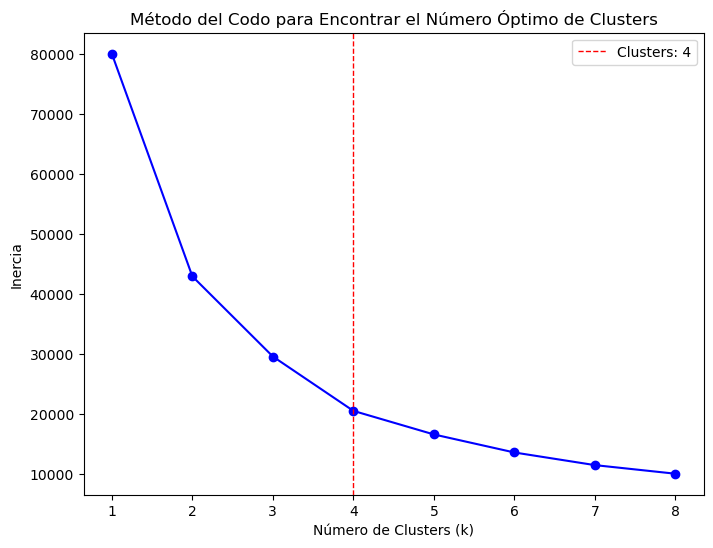

In [93]:
# Graficar el codo con el número óptimo de clusters seleccionado
plt.figure(figsize=(8, 6))
plt.plot(range(1, 9), inercia, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Encontrar el Número Óptimo de Clusters')

# Marcar el número de clusters seleccionado
num_clusters_seleccionado = 4  # Reemplaza con tu número de clusters seleccionado
plt.axvline(x=num_clusters_seleccionado, color='r', linestyle='--', linewidth=1, label=f'Clusters: {num_clusters_seleccionado}')
plt.legend()

plt.show()

In [94]:
# Definir el número de clusters
num_clusters = 4

# Crear una instancia de KMeans con el número de clusters y el random state
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajustar el modelo a los datos
kmeans.fit(df_modelo)

C:\Users\jmlopezm\AppData\Local\anaconda3\envs\julian\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=42)

In [97]:
result['cluster'] = kmeans.labels_

In [98]:
result

,user_id,total_debito_transactions,total_credito_transactions,Promedio_debito_amount,Promedio_credito_amount,transactions_per_hour_debito,transactions_per_day_debito,transactions_per_week_debito,transactions_per_month_debito,transactions_per_hour_credito,transactions_per_day_credito,transactions_per_week_credito,transactions_per_month_credito,cluster
0,00000158a82e34eb0848d767d09f811d,11,0.0,86.464800,0.000000,0.002011,0.048246,0.337719,1.447368,0.000000,0.000000,0.000000,0.000000,0
1,000004f4a6f3ac93f454a5dc04b2a252,8,1.0,151.583603,594.445501,0.014692,0.347826,2.434783,10.434783,0.001837,0.043478,0.304348,1.304348,3
2,00000c80915f64c9bcbf1e85a2e5f3ec,1,0.0,118.889100,0.000000,0.000000,1.000000,7.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0
3,00000e01abb58a22cbb3cab74c316df7,3,0.0,230.644854,0.000000,0.001843,0.044118,0.308824,1.323529,0.000000,0.000000,0.000000,0.000000,2
4,0000180e94707c0d90547614c17076bf,13,0.0,80.478776,0.000000,0.009015,0.213115,1.491803,6.393443,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2350858,ffffbe96808cdeaba25184e9f1edbaba,5,0.0,99.866844,0.000000,0.001507,0.035971,0.251799,1.079137,0.000000,0.000000,0.000000,0.000000,0
2350859,ffffd28ca3ca1b46d728e5d75e21c428,48,0.0,107.247876,0.000000,0.006975,0.167247,1.170732,5.017422,0.000000,0.000000,0.000000,0.000000,0
2350860,ffffecb14c622ff657fb8668300c7540,5,0.0,164.066958,0.000000,0.050009,1.000000,7.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0
2350861,ffffed6a586baff30e8cd9f18a73290e,7,0.0,317.603739,0.000000,0.001153,0.027559,0.192913,0.826772,0.000000,0.000000,0.000000,0.000000,2


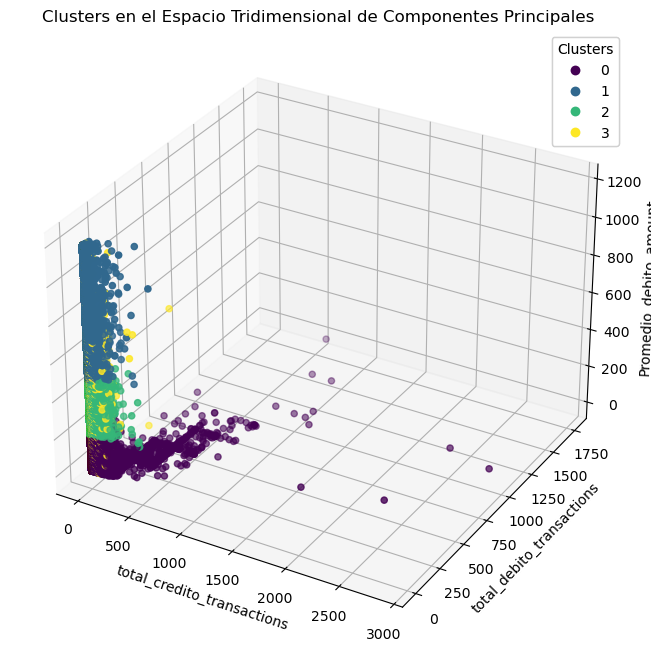

In [99]:
# Crear una figura 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los clusters en el espacio tridimensional
scatter = ax.scatter(
    result['total_credito_transactions'], 
    result['total_debito_transactions'], 
    result['Promedio_debito_amount'], 
    c=result['cluster'], 
    cmap='viridis', 
    s=20
)

# Etiquetas de los ejes
ax.set_xlabel('total_credito_transactions')
ax.set_ylabel('total_debito_transactions')
ax.set_zlabel('Promedio_debito_amount')
# Líneas rojas que cruzan el centro de cada eje
ax.plot([0, 0], [0, 0], [-5, 5], color='red', linestyle='--')  # Eje x
ax.plot([0, 0], [-5, 5], [0, 0], color='red', linestyle='--')  # Eje y
ax.plot([-5, 5], [0, 0], [0, 0], color='red', linestyle='--')  # Eje z

# Leyenda
legend = ax.legend(*scatter.legend_elements(), title='Clusters', loc='upper right')
ax.add_artist(legend)
# ax.view_init(elev=100, azim=200)
plt.title('Clusters en el Espacio Tridimensional de Componentes Principales')
plt.show()

In [101]:
result

,user_id,total_debito_transactions,total_credito_transactions,Promedio_debito_amount,Promedio_credito_amount,transactions_per_hour_debito,transactions_per_day_debito,transactions_per_week_debito,transactions_per_month_debito,transactions_per_hour_credito,transactions_per_day_credito,transactions_per_week_credito,transactions_per_month_credito,cluster
0,00000158a82e34eb0848d767d09f811d,11,0.0,86.464800,0.000000,0.002011,0.048246,0.337719,1.447368,0.000000,0.000000,0.000000,0.000000,0
1,000004f4a6f3ac93f454a5dc04b2a252,8,1.0,151.583603,594.445501,0.014692,0.347826,2.434783,10.434783,0.001837,0.043478,0.304348,1.304348,3
2,00000c80915f64c9bcbf1e85a2e5f3ec,1,0.0,118.889100,0.000000,0.000000,1.000000,7.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0
3,00000e01abb58a22cbb3cab74c316df7,3,0.0,230.644854,0.000000,0.001843,0.044118,0.308824,1.323529,0.000000,0.000000,0.000000,0.000000,2
4,0000180e94707c0d90547614c17076bf,13,0.0,80.478776,0.000000,0.009015,0.213115,1.491803,6.393443,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2350858,ffffbe96808cdeaba25184e9f1edbaba,5,0.0,99.866844,0.000000,0.001507,0.035971,0.251799,1.079137,0.000000,0.000000,0.000000,0.000000,0
2350859,ffffd28ca3ca1b46d728e5d75e21c428,48,0.0,107.247876,0.000000,0.006975,0.167247,1.170732,5.017422,0.000000,0.000000,0.000000,0.000000,0
2350860,ffffecb14c622ff657fb8668300c7540,5,0.0,164.066958,0.000000,0.050009,1.000000,7.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0
2350861,ffffed6a586baff30e8cd9f18a73290e,7,0.0,317.603739,0.000000,0.001153,0.027559,0.192913,0.826772,0.000000,0.000000,0.000000,0.000000,2


In [100]:
df

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,transaction_date_only,transaction_hour,transaction_day,transaction_month,amount_trans,transaction_day_num,hora,transaction_day_name
0,075d178871d8d48502bf1f54887e52fe,aa8dacff663072244d0a8ab6bbe36b93,824b2af470cbe6a65b15650e03b740fc,2021-09-12 18:32:03,648e257c9d74909a1f61c54b93a9e1b3,ba42d192a145583ba8e7bf04875f837f,178.333650,CREDITO,2021-09-12,18,Sunday,September,178.333650,12,18,Sunday
1,075d178871d8d48502bf1f54887e52fe,a53bb81bd0bba2ae2535bda7ea5a550c,2d8d34be7509a6b1262336d036fdb324,2021-09-12 18:31:58,c0b62f9046c83ea5543ea46a497a4d6e,5cfff960ea6d732c1ba3e63d24f3be52,35.666730,CREDITO,2021-09-12,18,Sunday,September,35.666730,12,18,Sunday
2,075d178871d8d48502bf1f54887e52fe,79f893ea65c06fe2933f3847c88c272f,5eeb18254850b21af0a6bb2697913cd3,2021-09-12 18:31:56,872d10143fc0ac7d5de467806f6bef81,c97e63a92c82c7217b333635d75928ed,142.666920,CREDITO,2021-09-12,18,Sunday,September,142.666920,12,18,Sunday
3,075d178871d8d48502bf1f54887e52fe,ce577223699dbdc119df2ab8a35457fe,5221a599856c0a0588ed9ffd150edd3b,2021-09-12 18:31:10,2e35cfe7860a480a93e1c83e99843579,fc09bdd00f283222d65eaff4d00a6594,8.322237,CREDITO,2021-09-12,18,Sunday,September,8.322237,12,18,Sunday
4,075d178871d8d48502bf1f54887e52fe,0ce7ab2950e7a788a608f881aec0f8f0,971e55ef12d80ec070ea4f6750c8b892,2021-09-12 18:31:07,995bc89e4c4e00334f1f90c4a55f4729,213527e8ba94fcaf2f9378969f9f6abc,32.100057,CREDITO,2021-09-12,18,Sunday,September,32.100057,12,18,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10758495,838a8fa992a4aa2fb5a0cf8b15b63755,d3b13edf7cb64280616840751348d916,3ed43ebad2054f6a8eff18b431f0e9a9,2021-11-29 15:48:16,8210a8f7e6b39cfc4f2b21212d18449d,69924bf8abb336410c8651f939124b48,237.778200,CREDITO,2021-11-29,15,Monday,November,237.778200,29,15,Monday
10758496,838a8fa992a4aa2fb5a0cf8b15b63755,eadd1cc3d7f8c4a184575a3b40449015,81f8b6411c8d4f28a94fce21a134546c,2021-11-30 10:57:33,78adeb5e6eb3e03c27d8c9f078a8fd2e,e992ff01e005927af8b343385adf3744,26.155602,CREDITO,2021-11-30,10,Tuesday,November,26.155602,30,10,Tuesday
10758497,838a8fa992a4aa2fb5a0cf8b15b63755,f19c70c14bae6f6c8d53c2a85f5f59f6,55fb0b01915693a7d5de686f9f4b1cb6,2021-11-30 11:01:07,90865ae9ab4d82a1feec13eee9a4a303,356058d6c9548879be6ef65a9733ea44,594.445501,CREDITO,2021-11-30,11,Tuesday,November,594.445501,30,11,Tuesday
10758498,838a8fa992a4aa2fb5a0cf8b15b63755,8d43b7b55023ccae39735707a811f38f,55fb0b01915693a7d5de686f9f4b1cb6,2021-11-30 11:02:05,90865ae9ab4d82a1feec13eee9a4a303,356058d6c9548879be6ef65a9733ea44,172.389195,CREDITO,2021-11-30,11,Tuesday,November,172.389195,30,11,Tuesday


In [102]:
# Realizar el merge de df y result por 'user_id'
df_final= pd.merge(df, result, on='user_id', how='left')

### Resultado
La función asignar_operacion es un ejemplo de cómo podría implementarse un modelo heurístico para la detección de alertas transaccionales dentro de diferentes segmentos de usuarios. En este caso, la función asigna una operación como "normal" o "alerta" según condiciones predefinidas basadas en las características de cada segmento (o cluster) de usuarios, como la cantidad de transacciones por hora de crédito, débito y el monto de las transacciones. Este enfoque simula un proceso de alerta transaccional, donde los usuarios en cada grupo tienen diferentes umbrales para generar alertas, lo cual podría formar parte de un modelo basado en reglas o heurísticas. La idea es detectar comportamientos inusuales o riesgosos en función de las transacciones realizadas, permitiendo que el modelo se adapte a las características específicas de cada segmento de clientes y proporcionando una base para decisiones de monitoreo y control de riesgos en tiempo real.
- Se tendrian en cuenta variables por hora, dia, semana,mes, segmento, monto, si el cliente llega a cambiar de segmento en la corrida dle modelo y evaluar el porque, y adicionalmente se realizaria un tablero de power bi donde se pueda realizar un control a la evolucion de cada segmento, montaria todo a una base de datos sql donde controle todas las novedades
### Todos estos procesos los puedo realizar si se me solicita para validar mis conocimientos, no lo hice por falta de tiempo (dado que recibi la prueba cuando estaba de viaje y solo tuve la tarde de hoy para hacerla)

### Nota: No ejecute las alertas porque mi computador no soporto tanta información 

In [ ]:
# Definir las condiciones para cada cluster
def asignar_operacion(row):
    if row['cluster'] == 0:
        # Cluster 0: Definir rangos para alertas en 'transactions_per_hour_credito', 'transactions_per_hour_debito' y 'amount'
        if row['transactions_per_hour_credito'] > 10 or row['transactions_per_hour_debito'] > 15 or row['transaction_amount'] > 200:
            return 'alerta'
        else:
            return 'normal'
    elif row['cluster'] == 1:
        # Cluster 1: Definir rangos para alertas en 'transactions_per_hour_credito', 'transactions_per_hour_debito' y 'amount'
        if row['transactions_per_hour_credito'] > 8 or row['transactions_per_hour_debito'] > 12 or row['transaction_amount'] > 150:
            return 'alerta'
        else:
            return 'normal'
    elif row['cluster'] == 2:
        # Cluster 2: Definir rangos para alertas en 'transactions_per_hour_credito', 'transactions_per_hour_debito' y 'amount'
        if row['transactions_per_hour_credito'] > 6 or row['transactions_per_hour_debito'] > 10 or row['transaction_amount'] > 220:
            return 'alerta'
        else:
            return 'normal'
    elif row['cluster'] == 3:
        # Cluster 3: Definir rangos para alertas en 'transactions_per_hour_credito', 'transactions_per_hour_debito' y 'amount'
        if row['transactions_per_hour_credito'] > 5 or row['transactions_per_hour_debito'] > 8 or row['transaction_amount'] > 2000:
            return 'alerta'
        else:
            return 'normal'

# Aplicar la función para asignar 'operacion' a cada fila del DataFrame
df_final['operacion'] = df_final.apply(asignar_operacion, axis=1)

# Mostrar los primeros resultados
df_final[['user_id', 'cluster', 'transactions_per_hour_credito', 'transactions_per_hour_debito', 'transaction_amount', 'operacion']].head()